In [1]:
%config InlineBackend.figure_format = 'retina'

In [381]:
import seaborn as sns

# import hdf5plugin, h5py
import torch, tables
from torch import nn
import os
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from functools import partial
from tqdm.auto import tqdm
from typing import Any
import torchvision
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
from dataclasses import dataclass
from typing import Callable
import cv2, functools, glia
import pytorch_lightning as pl
from pytorch_lightning.loggers.neptune import NeptuneLogger
import neptune
import neptunecontrib.monitoring.optuna as optuna_utils
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback
import optuna
from datetime import datetime
import socket, plotly
from pathlib import Path
import torch.nn, gc, psycopg2
import torch.nn as nn
import sys, traceback
from glia.reconstructions.lib import resize_3d, gray_3d, ImageData, RetinaData, \
     ConcatDataset, ImageRetina
from sqlalchemy import create_engine
import pandas as pd

# sys.argv = [None, "/mnt/fs1/tbenst/200623_faces/R1_E3_AMES_200min_200f_14l_rgb.h5",
#             "/mnt/fs1/tbenst/models/3brain/", "9"]

sys.argv = [None, "/data/uw/200623_faces/merged/R1_E3_AMES_200min_200f_14l_rgb.h5",
           "/data/uw/models/", "0"]

filepath = sys.argv[1]
# model_base_dir = "/storage/models/retina-reconstruction"
model_base_dir = sys.argv[2]
gpus = [ int(sys.argv[3]) ]

pw = os.environ["POSTGRES_OPTUNA_PASSWORD"]
server = os.environ["POSTGRES_SERVER"]
port = os.environ["POSTGRES_PORT"]
user = os.environ["POSTGRES_OPTUNA_USER"]
# validate password

engine = create_engine(f'postgresql://{user}:{pw}@{server}:{port}/optuna')
with engine.connect() as connection:
    result = connection.execute("select * from trials limit 1;")


# open file
hdf5 = tables.open_file(filepath,'r')
h5 = hdf5.root

# crop image
imgs = h5["images"][0:100]
avg_img = np.mean(imgs, axis=(0,3))
y,x = np.where(avg_img>5)
xleft = min(x)
xright = max(x)
ytop = min(y)
ybot = max(y)

In [382]:
image_dset = ImageData(h5["images"], crop=[ytop,ybot,xleft,xright])
# retina_dset = RetinaOnOffData(h5["data"], no_units=False, on_or_off=False)
nbins = 1
retina_dset = RetinaData(h5["data"], nbins=nbins)
(image_dset[0].shape, retina_dset[0].shape)

(torch.Size([1, 64, 64]), torch.Size([1, 6, 64, 64]))

In [383]:
# from https://discuss.pytorch.org/t/writing-a-simple-gaussian-noise-layer-in-pytorch/4694/8
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.expand(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 

In [384]:
# fits noise receptive fields...
class DeepRetina(pl.LightningModule):
    def __init__(self, filter1=16, filter2=8, lr=3e-5, kernel1=15, kernel2=9, weight_decay=0.,
                nUnits=0, nTime=10, meaH=64, meaW=64, imgH=32, imgW=32,
                example_input_array=None, save_dir=None):
        super(DeepRetina, self).__init__()
        self.meaH = meaH
        self.meaW = meaW
        self.imgH = imgH
        self.imgW = imgW
        self.lr = lr
        self.weight_decay = weight_decay
        self.nUnits = nUnits
        self.save_hyperparameters()
        self.conv1 = nn.Conv2d(in_channels=1,
            out_channels=filter1, kernel_size=kernel1,
            padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=filter1,
            out_channels=filter2, kernel_size=kernel2,
            padding=0)
        
        self.gn = GaussianNoise()
        smallW = meaW-filter1-filter2+2 # not validated..
        smallH = meaH-filter1-filter2+2 # not validated..
        linear_in = smallW*smallH*filter2
        self.dense = torch.nn.Linear(linear_in,
                                     self.meaH * self.meaW * self.nUnits)

    
    def forward(self, x):
        bz = x.shape[0]
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
        x = F.relu(self.gn(self.conv1(x)))
        x = F.relu(self.gn(self.conv2(x)))
        dense_out = self.dense(x.reshape(bz, -1))
        x = F.softplus(dense_out)
        return {"retina_pred": x.reshape(bz, self.nUnits, self.meaH, self.meaW),
                "dense_out": dense_out}
        
    
    def loss(self, batch, batch_idx):        
        images, retina = batch
        bz = images.shape[0]
        out_dict = self(images)
        retina_pred, dense_out = out_dict["retina_pred"], out_dict["dense_out"]
        weight_loss = (self.conv1.weight.norm(2) + self.conv2.weight.norm(2)).mean()
        poisson_loss = F.poisson_nll_loss(retina_pred, retina, log_input=False)
        activity_loss = dense_out.norm(1).mean()
#         loss = 1e-3*weight_loss + poisson_loss + 1e-3*activity_loss
#         loss = F.mse_loss(retina_pred, retina) + 1e-3*weight_loss + 1e-3*activity_loss
#         loss = F.mse_loss(retina_pred, retina)
        loss = poisson_loss
        return {"loss": loss, "weight_loss": weight_loss,
                "poisson_loss": poisson_loss, "activity_loss": activity_loss, 
               }
        
    
    def training_step(self, batch, batch_idx):
        loss_dict = self.loss(batch, batch_idx)
        loss = loss_dict["loss"]
        result = pl.TrainResult(loss)
        result.log('poisson_loss', loss_dict["poisson_loss"], prog_bar=True)
        return result
        
    def validation_step(self, batch, batch_idx):
        loss_dict = self.loss(batch, batch_idx)
        loss = loss_dict["loss"]
        result = pl.EvalResult(checkpoint_on=loss)
#         result.log('val_mse_loss', recon_loss, on_epoch=True)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
            weight_decay=self.weight_decay)
        return optimizer
    
class ConvRetina(pl.LightningModule):
    def __init__(self, filter1=16, filter2=8, lr=3e-5, kernel1=15, kernel2=9, weight_decay=0.,
                nUnits=0, nTime=10, meaH=64, meaW=64, imgH=32, imgW=32,
                example_input_array=None, save_dir=None, einsum=True, nCelltypes=8):
        super(ConvRetina, self).__init__()
        self.meaH = meaH
        self.meaW = meaW
        self.imgH = imgH
        self.imgW = imgW
        self.lr = lr
        self.weight_decay = weight_decay
        self.nUnits = nUnits
        self.save_hyperparameters()
        self.einsum = einsum
        self.nCelltypes = nCelltypes
        self.conv1 = nn.Conv2d(in_channels=1,
            out_channels=filter1, kernel_size=kernel1,
            padding=kernel1//2)
        
        self.conv2 = nn.Conv2d(in_channels=filter1,
            out_channels=filter2, kernel_size=kernel2,
            padding=kernel2//2)
        
        self.gn = GaussianNoise()
        
        
        if einsum:
            cl = torch.FloatTensor(nUnits, self.nCelltypes, 64, 64).fill_(
                1/self.nCelltypes)
            self.celltype_likelihood = nn.Parameter(torch.tensor(cl)) # uniform prior
            self.register_parameter(name='celltype', param=self.celltype_likelihood)
            conv3_out = nCelltypes
        else:
            
            conv3_out = nUnits
        
        self.conv3 = nn.Conv2d(in_channels=filter2,
            out_channels=conv3_out, kernel_size=kernel2,
            padding=kernel2//2)
        self.bias = torch.nn.Parameter(torch.Tensor(nUnits, meaH,meaW))
        torch.nn.init.constant_(self.bias, 0.0)
        
    
    def forward(self, x):
        bz = x.shape[0]
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
        x = F.relu(self.gn(self.conv1(x)))
        x = F.relu(self.gn(self.conv2(x)))
        x = F.relu(self.gn(self.conv3(x)))
        if self.einsum:
            x = torch.einsum("bnhw,cnhw->bchw", x, self.celltype_likelihood)
            x = x.reshape(-1,self.nUnits,64,64)
            x = F.softplus(x + self.bias[None])
        else:
            x = F.softplus(x + self.bias[None])
        return {"retina_pred": x}
        
    
    def loss(self, batch, batch_idx):        
        images, retina = batch
        bz = images.shape[0]
        out_dict = self(images)
        retina_pred = out_dict["retina_pred"]
        weight_loss = (self.conv1.weight.norm(2) + self.conv2.weight.norm(2)).mean()
        poisson_loss = F.poisson_nll_loss(retina_pred, retina, log_input=False)
#         loss = 1e-3*weight_loss + poisson_loss + 1e-3*activity_loss
#         loss = F.mse_loss(retina_pred, retina) + 1e-3*weight_loss + 1e-3*activity_loss
#         loss = F.mse_loss(retina_pred, retina)
        loss = poisson_loss
        return {"loss": loss, "weight_loss": weight_loss,
                "poisson_loss": poisson_loss 
               }
        
    
    def training_step(self, batch, batch_idx):
        loss_dict = self.loss(batch, batch_idx)
        loss = loss_dict["loss"]
        result = pl.TrainResult(loss)
        result.log('poisson_loss', loss_dict["poisson_loss"], prog_bar=True)
        return result
        
    def validation_step(self, batch, batch_idx):
        loss_dict = self.loss(batch, batch_idx)
        loss = loss_dict["loss"]
        result = pl.EvalResult(checkpoint_on=loss)
#         result.log('val_mse_loss', recon_loss, on_epoch=True)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
            weight_decay=self.weight_decay)
        return optimizer

In [386]:
nSamples = len(retina_dset)
train_idx = [i for i in range(nSamples) if (i+1)%5 != 0]
val_idx = np.arange(nSamples)[sldiff_ex_outSamples,10)]
test_idx = np.arange(nSamples)[slice(9,nSamples,10)]
dm = ImageRetina(image_dset, retina_dset,batch_size=50,
                 tvt_idxs=(train_idx, val_idx, test_idx))

now_str = datetime.now().isoformat()
save_dir = os.path.join(model_base_dir,
    now_str)

# MODEL_NAME="deepretina"
# model = DeepRetina(example_input_array=image_dset[0][None],
#                nUnits = 6, nTime=nbins, lr=4e-3)

MODEL_NAME="convretina"
model = ConvRetina(example_input_array=image_dset[0][None],
               nUnits = 6, nTime=nbins, lr=4e-3)

neptune_logger = NeptuneLogger(
    api_key=os.environ["NEPTUNE_API_TOKEN"],
    project_name="tbenst/retina",
    params=model.hparams,
    experiment_name=MODEL_NAME,  # Optional,
    tags=["deep-retina", "auto-lr-finder", "merged-data"],
)

monitor="val_mse_loss"
save_name = MODEL_NAME+"_{epoch}_{"+monitor+":.2f}"
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=os.path.join(save_dir,save_name),
    save_top_k=1,
    verbose=False,
    monitor=monitor,
    mode='min',
    prefix=''
)
    
trainer = pl.Trainer(gpus=[0], logger=neptune_logger, val_percent_check=0,
                     default_root_dir=save_dir, max_epochs=50, auto_lr_find=True)
trainer.fit(model, dm)

model.cuda()
ex_out = model(image_dset[1][None].cuda())["retina_pred"].sum((0,1)).detach().cpu().numpy()
plt.imshow(ex_out)
plt.colorbar()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 10)

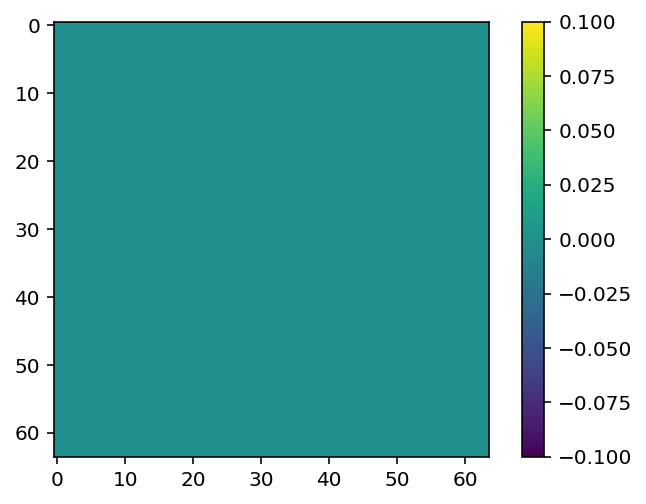

In [374]:
diff_ex_out = model(image_dset[100][None].cuda())["retina_pred"].sum((0,1)).detach().cpu().numpy()
plt.imshow(ex_out-diff_ex_out)
plt.colorbar()

In [156]:
import gc
gc.collect()

61

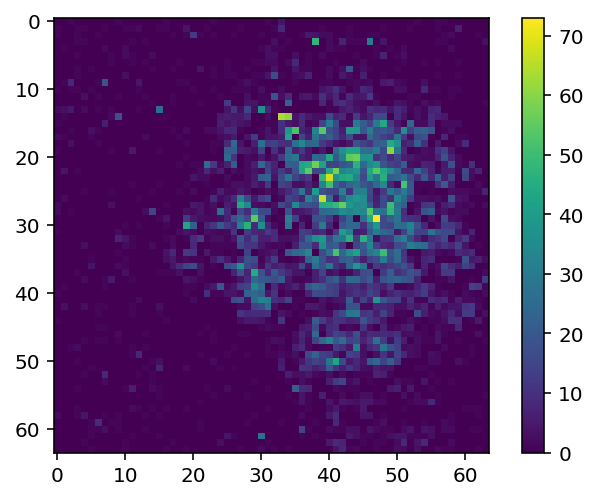

In [346]:
plt.imshow(retina_dset[1].sum((0,1)).numpy())
plt.colorbar()

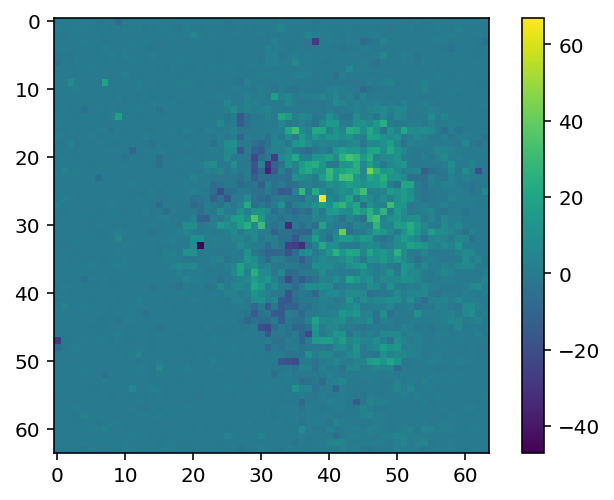

In [380]:
plt.imshow((retina_dset[1].sum((0,1)) - retina_dset[100].sum((0,1))).numpy())
plt.colorbar()

In [139]:
retina_out.shape

torch.Size([512, 6, 64, 64])

In [148]:
image_dset[0].shape

torch.Size([1, 64, 64])

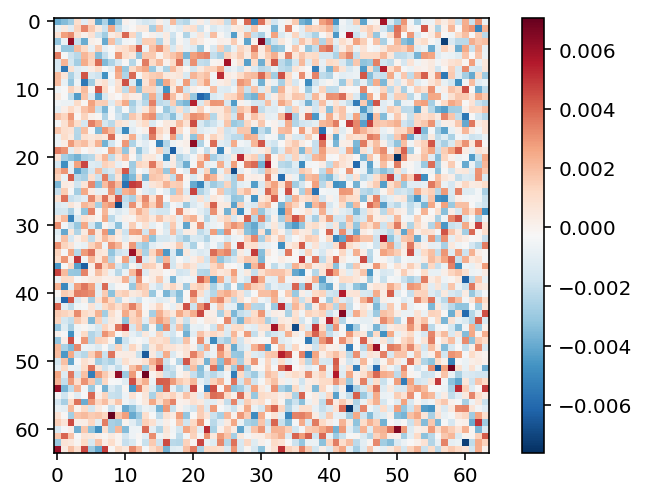

In [370]:
# receptive_field = torch.zeros(*retina_dset[0].shape[1:], 64, 64)
receptive_field = torch.zeros(64, 64).double().cuda()
N = 500
bz = 512
i, j = 27, 42
i, j = 30, 40
u = 0
with torch.no_grad():
    for b in range(N):
        white_noise = torch.normal(0.5,0.15,(bz, 1, 64, 64)).cuda()
        out_dict = model(white_noise)
        retina_out = out_dict["retina_pred"].double()
        weighted = (retina_out[:,u,i,j] * (white_noise.T-0.5)).T.mean(0)
        receptive_field += torch.squeeze(weighted)
receptive_field = (receptive_field/N).cpu().numpy()

cmax = np.max(np.abs(all_receptive_field[u,i,j]))
plt.imshow(all_receptive_field[u,i,j],cmap="RdBu_r")
#            ,clim=(-cmax,cmax))
plt.colorbar()

In [ ]:
# receptive_field = torch.zeros(*retina_dset[0].shape[1:], 64, 64)
receptive_field = torch.zeros(64, 64).double().cuda()
N = 1000
N = 2048*4
bz = 512
bz = 12
i, j = 27, 42
i, j = 30, 40
with torch.no_grad():
    for b in range(N):
        white_noise = torch.normal(0.5,0.15,(bz, 1, 64, 64)).cuda()
        out_dict = model(white_noise)
        retina_out = out_dict["retina_pred"].double()
        weighted = (retina_out[:,0,i,j] * (white_noise.T-0.5)).T.mean(0)
        receptive_field += torch.squeeze(weighted)
receptive_field = (receptive_field/N).cpu().numpy()

In [244]:
wn.T.shape

torch.Size([12, 1, 64, 64])

In [243]:
retina_out.reshape(-1, nrgc)[:,:,None, None].double().shape

torch.Size([12, 24576, 1, 1])

In [251]:
2**15*12

393216

In [353]:
import gc
gc.collect()
torch.cuda.memory.empty_cache()
imgH, imgW = image_dset[0].shape[1:]
# calculate rgc-weighted sum of white noise to estimate receptive field
# (done in-silico on model fit to RGC image responses)
receptive_field = torch.zeros(*retina_dset[0].shape[1:], imgH, imgW).double()
rgc_shape = retina_dset[0].shape[1:]
nrgc = np.prod(rgc_shape)
N = 2**12
bz = 14
# i, j = 30, 30
with torch.no_grad():
    for b in tqdm(range(N), total=N):
#         white_noise = torch.normal(0.5,0.15,(bz, 1, imgH, imgW)).cuda()
        white_noise = torch.empty((bz, 1, imgH, imgW), device=torch.device('cuda')).normal_(0.5, 0.15)
        out_dict = model(white_noise)
        retina_out = out_dict["retina_pred"]
        wn = white_noise.double() - 0.5
        weighted = (retina_out.reshape(-1, nrgc)[:,:,None, None].double() * wn
                    ).mean(0)
        receptive_field += (weighted.reshape(*rgc_shape, imgH, imgW)).cpu()
all_receptive_field = receptive_field.numpy() / N

Text(0.5, 1.0, '(10,10)_0')

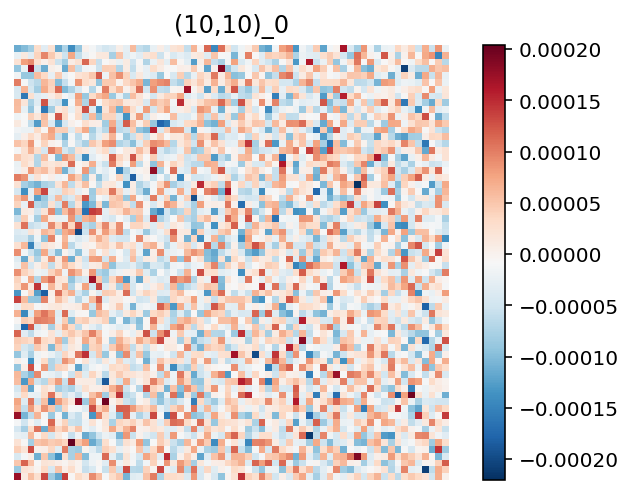

In [390]:
u, i, j = [0,10,10]
cmax = np.max(np.abs(all_receptive_field[u,i,j]))
plt.imshow(all_receptive_field[u,i,j],cmap="RdBu_r")
#            ,clim=(-cmax,cmax))
plt.colorbar()
plt.axis('off')
plt.title(f"({i},{j})_{u}")

Text(0.5, 1.0, '(10,50)_0')

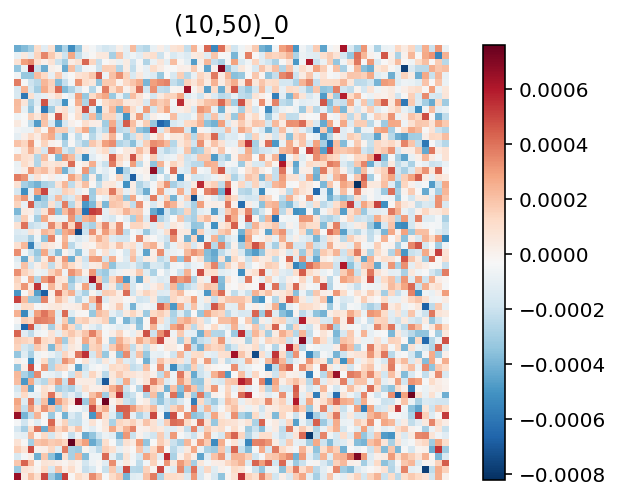

In [391]:
u, i, j = [0,10,50]
cmax = np.max(np.abs(all_receptive_field[u,i,j]))
plt.imshow(all_receptive_field[u,i,j],cmap="RdBu_r")
#            ,clim=(-cmax,cmax))
plt.colorbar()
plt.axis('off')
plt.title(f"({i},{j})_{u}")

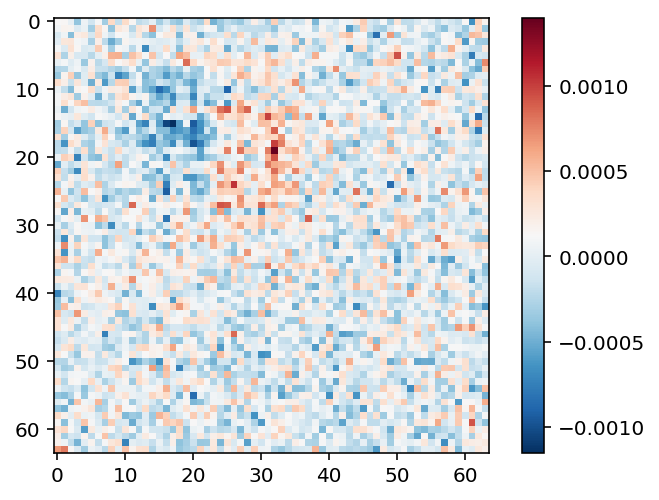

In [287]:
u, i, j = [0,20,20]
cmax = np.max(np.abs(all_receptive_field[u,i,j]))
plt.imshow(all_receptive_field[u,i,j],cmap="RdBu_r")
#            ,clim=(-cmax,cmax))
plt.colorbar()

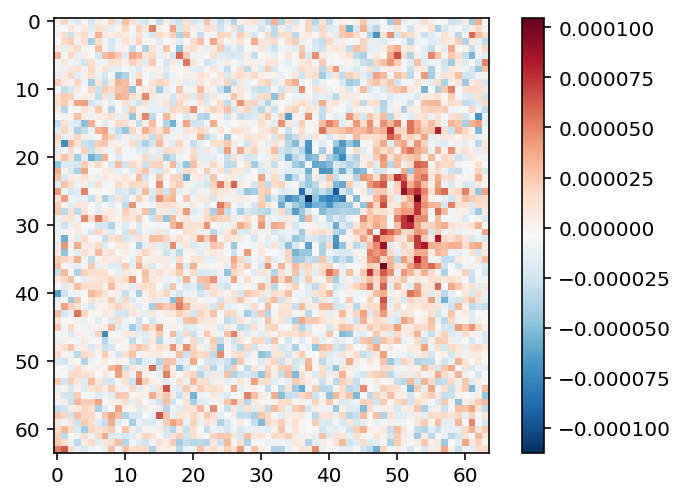

In [300]:
u, i, j = [1,30,41]
cmax = np.max(np.abs(all_receptive_field[u,i,j]))
plt.imshow(all_receptive_field[u,i,j],cmap="RdBu_r")
#            ,clim=(-cmax,cmax))
plt.colorbar()

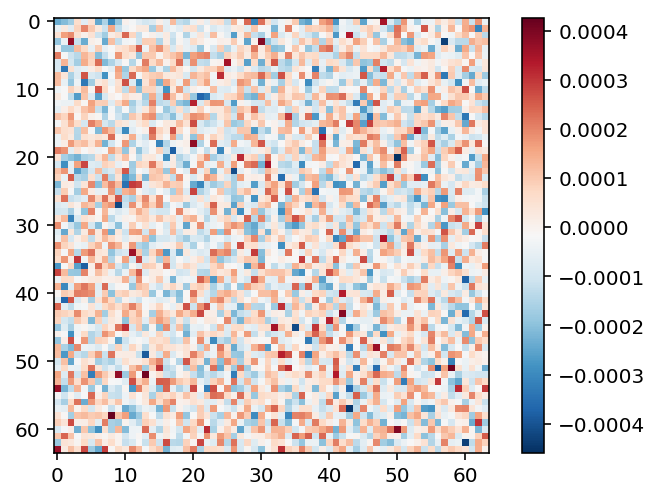

In [389]:
u, i, j = [0,30,41]
cmax = np.max(np.abs(all_receptive_field[u,i,j]))
plt.imshow(all_receptive_field[u,i,j],cmap="RdBu_r")
#            ,clim=(-cmax,cmax))
plt.colorbar()

In [267]:
rf_max = np.abs(all_receptive_field).sum((3,4))
ind = np.unravel_index(np.argmax(rf_max), rf_max.shape)
ind

(0, 33, 21)

In [388]:
from scipy import ndimage
ndimage.measurements.center_of_mass(all_receptive_field[u,i,j])

(162.17410346627506, 0.32574653913548973)

In [350]:
# receptive_field = torch.zeros(*retina_dset[0].shape[1:], 64, 64)
receptive_field = torch.zeros(64, 64).double().cuda()
N = 1000
bz = 512
# i, j = 27, 42
i, j = 30, 30
u = 0
with torch.no_grad():
    for b in range(N):
        white_noise = torch.normal(0.5,0.15,(bz, 1, 64, 64)).cuda()
        out_dict = model(white_noise)
        retina_out = out_dict["retina_pred"].double()
        weighted = (retina_out[:,0,i,j] * (white_noise.T-0.5)).T.mean(0)
        receptive_field += torch.squeeze(weighted)
receptive_field = (receptive_field/N).cpu().numpy()

In [258]:
np.save("/data/uw/200623_faces/R1_E3_conv_encoder_receptive_fields.npy", all_receptive_field)

In [260]:
summed_rf = np.abs(all_receptive_field).sum((3,4))

Text(0.5, 1.0, '(30,30)_0')

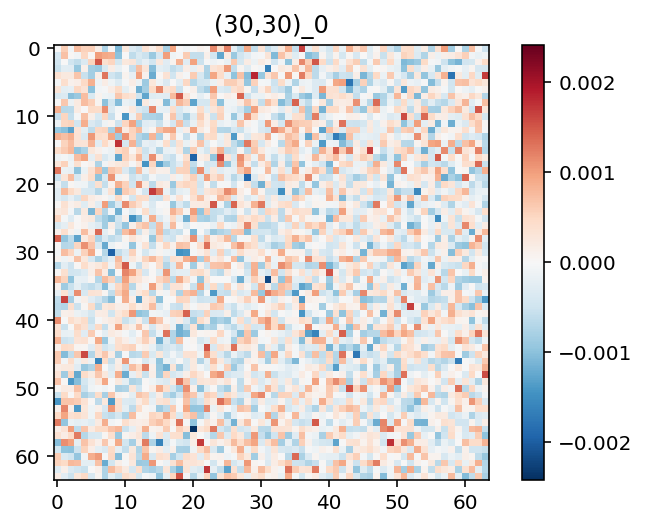

In [351]:
cmax = np.max(np.abs(receptive_field))
plt.imshow(receptive_field,cmap="RdBu_r",clim=(-cmax,cmax))
plt.colorbar()
u = 0
plt.title(f"({i},{j})_{u}")

In [239]:
# receptive_field = torch.zeros(*retina_dset[0].shape[1:], 64, 64)
receptive_field = torch.zeros(64, 64).double().cuda()
N = 1000
N = 2048*4
bz = 512
bz = 12
i, j = 27, 42
i, j = 30, 40
with torch.no_grad():
    for b in range(N):
        white_noise = torch.normal(0.5,0.15,(bz, 1, 64, 64)).cuda()
        out_dict = model(white_noise)
        retina_out = out_dict["retina_pred"].double()
        weighted = (retina_out[:,0,i,j] * (white_noise.T-0.5)).T.mean(0)
        receptive_field += torch.squeeze(weighted)
receptive_field = (receptive_field/N).cpu().numpy()

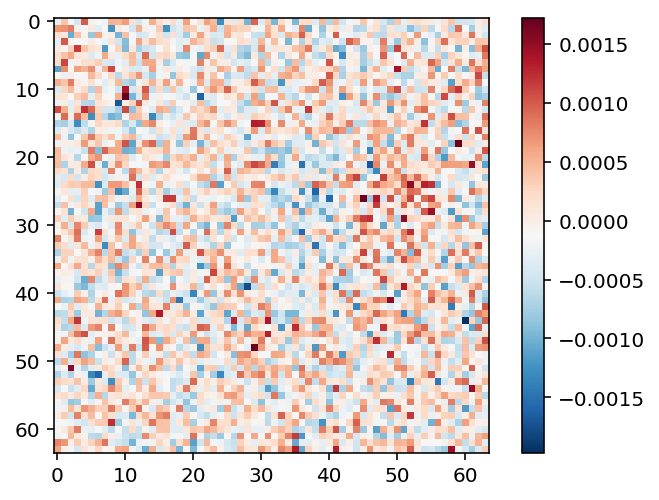

In [240]:
plt.imshow(receptive_field,cmap="RdBu_r")
plt.colorbar()

## Archive

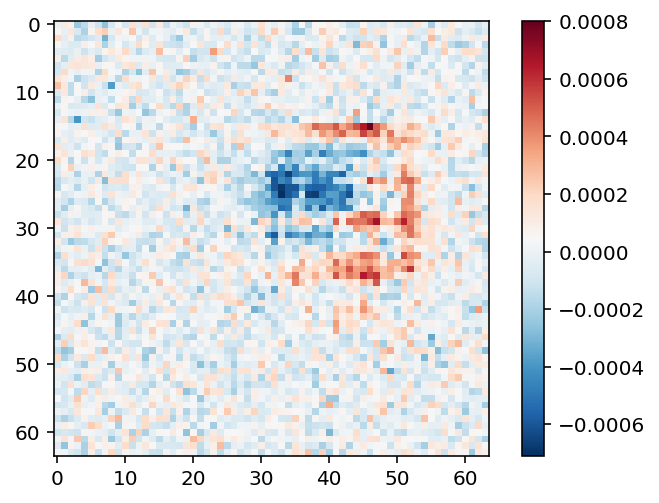

In [128]:
plt.imshow(receptive_field,cmap="RdBu_r")
plt.colorbar()